/N/u/shatumma/Quartz/.local/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


CUDA available: False
Input shape: torch.Size([2128, 2000])


/N/soft/rhel8/python/gnu/3.11.4/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


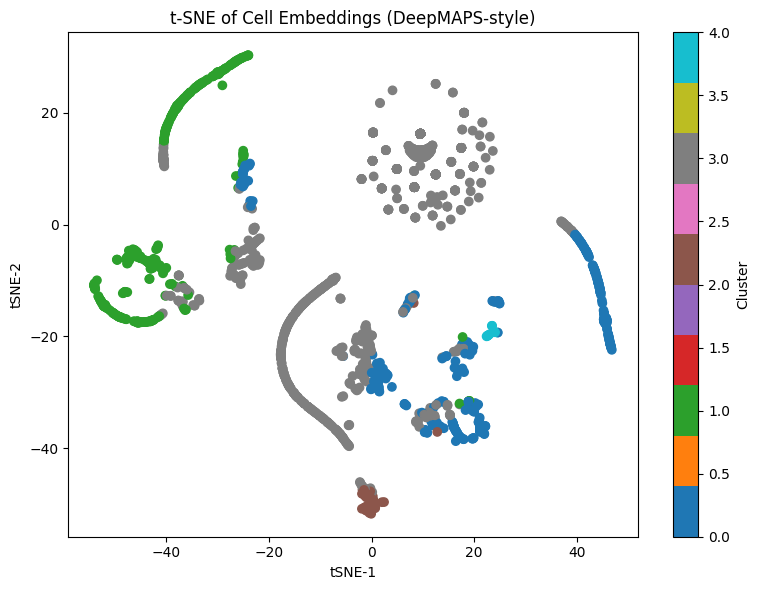

Project complete. Results saved.


In [6]:
# DeepMAPS: Mouse scRNA-seq Network Inference Project

# ✅ Step 1: Imports and Setup
import os
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import scanpy as sc

# ✅ Step 2: Load Raw scRNA-seq Data (10x format or h5ad)
data_type = "10x"  # Options: "10x" or "h5ad"
data_path = "Data"  # Folder containing matrix.mtx, genes.tsv, barcodes.tsv

if data_type == "10x":
    adata = sc.read_10x_mtx(data_path, var_names="gene_symbols", cache=True)
elif data_type == "h5ad":
    adata = sc.read_h5ad("your_data.h5ad")

# ✅ Step 3: Preprocess the AnnData object
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata)

# ✅ Step 4: Export Expression Matrix to CSV
#expression_df = pd.DataFrame(adata.X.toarray(), index=adata.obs_names, columns=adata.var_names)
expression_df = pd.DataFrame(adata.X, index=adata.obs_names, columns=adata.var_names)

expression_df.to_csv("expression_matrix.csv")

# ✅ Step 5: Torch Setup
print("CUDA available:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Step 6: Load Processed CSV and Standardize
df = pd.read_csv("expression_matrix.csv", index_col=0)
df = df.astype(float)
scaler = StandardScaler()
X = scaler.fit_transform(df.values)

# ✅ Step 7: Convert to Torch Tensor
data_tensor = torch.tensor(X, dtype=torch.float32).to(device)
print("Input shape:", data_tensor.shape)

# ✅ Step 8: Placeholder for DeepMAPS Model Pipeline
cell_embeddings = data_tensor[:, :10].cpu().detach().numpy()
np.savetxt("cell_embeddings.csv", cell_embeddings, delimiter=",")

# ✅ Step 9: Cluster Cells and Visualize
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(cell_embeddings)
kmeans = KMeans(n_clusters=5, random_state=42).fit(cell_embeddings)

plt.figure(figsize=(8,6))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=kmeans.labels_, cmap='tab10')
plt.title("t-SNE of Cell Embeddings (DeepMAPS-style)")
plt.xlabel("tSNE-1")
plt.ylabel("tSNE-2")
plt.colorbar(label="Cluster")
plt.tight_layout()
plt.savefig("deepmaps_tsne_plot.png")
plt.show()

# ✅ Step 10: Save Cluster Assignments
cell_clusters = pd.DataFrame({
    "cell_id": df.index,
    "cluster": kmeans.labels_
})
cell_clusters.to_csv("cell_clusters.csv", index=False)

print("Project complete. Results saved.")


In [7]:
sc.pp.neighbors(adata, use_rep="X")  # use the PCA space from preprocessing
sc.tl.diffmap(adata)


2025-04-14 22:07:47.781387: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-14 22:07:50.109156: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-14 22:08:13.061159: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [8]:
adata.uns['iroot'] = 0  # Index of root cell (can be adjusted)
sc.tl.dpt(adata)


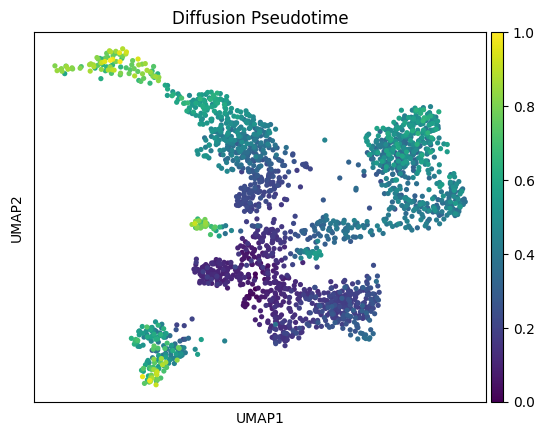

In [10]:
sc.tl.umap(adata)

sc.pl.umap(adata, color=['dpt_pseudotime'], title="Diffusion Pseudotime")


/N/u/shatumma/Quartz/.local/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/N/u/shatumma/Quartz/.local/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/N/u/shatumma/Quartz/.local/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/N/u/shatumma/Quartz/.local/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/N/u/shatumma/Quartz/.local/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.l

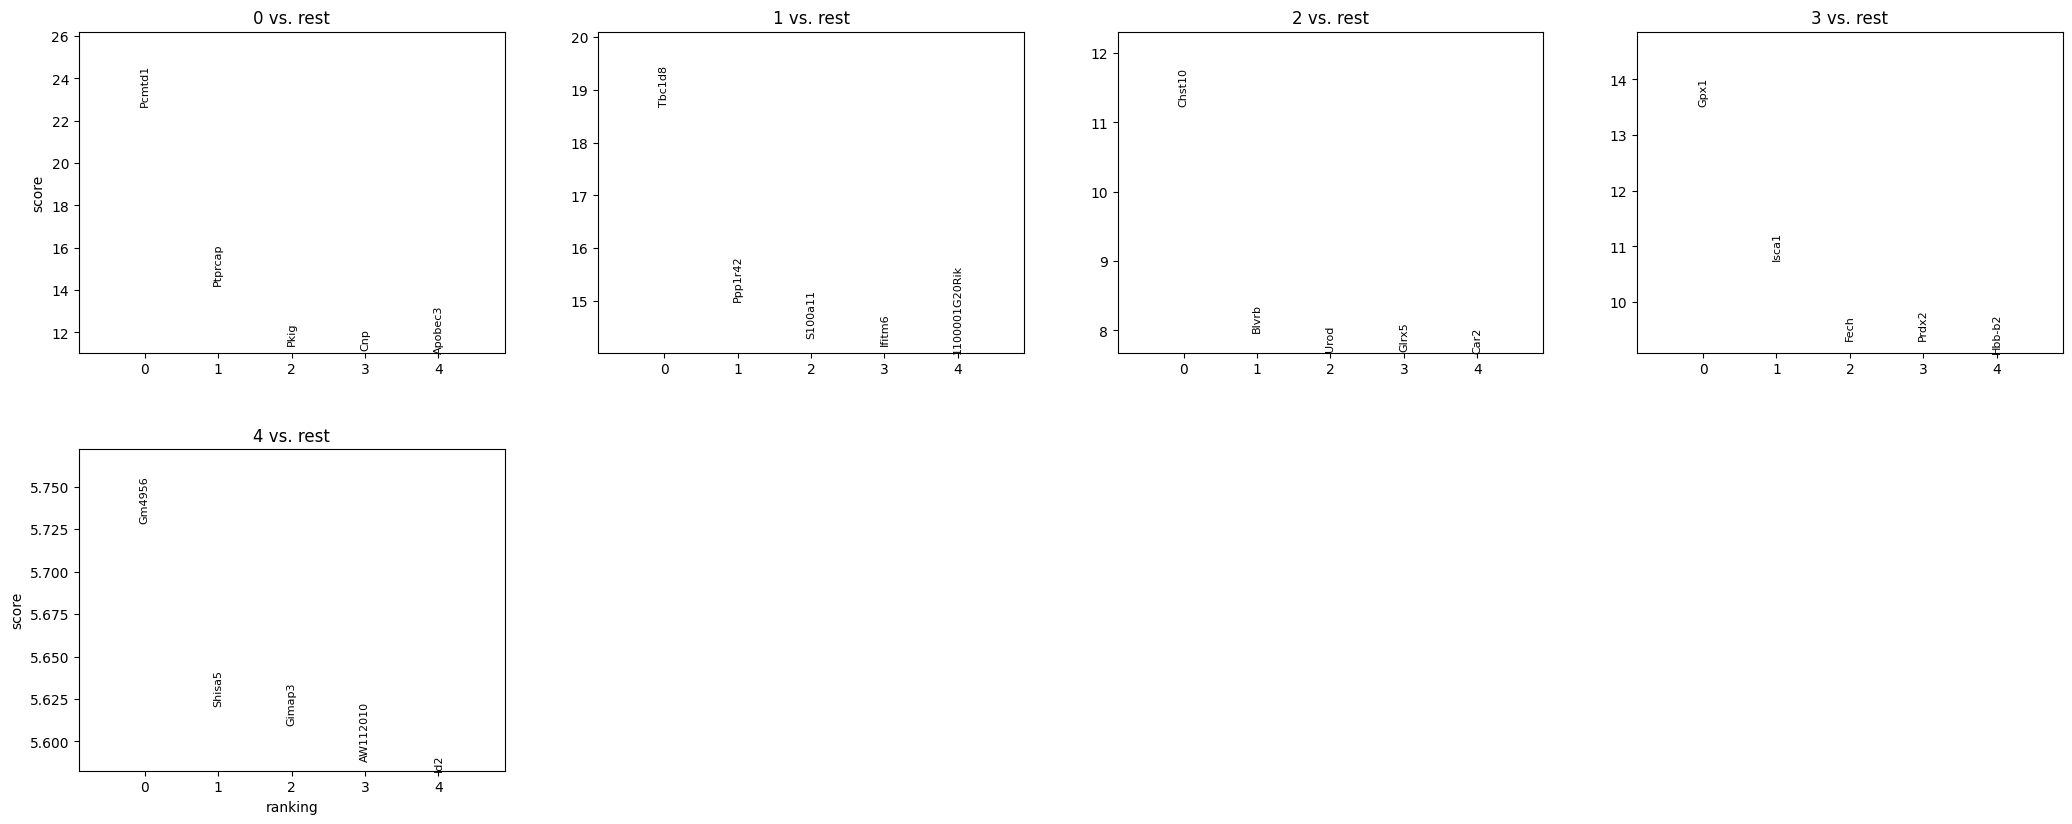

In [11]:
# Step 1: Add cluster info to AnnData
adata.obs['cluster'] = pd.read_csv("cell_clusters.csv")['cluster'].values.astype(str)

# Step 2: Re-run neighbors using PCA or UMAP (if needed)
sc.pp.pca(adata)
sc.pp.neighbors(adata)

# Step 3: Run differential gene expression per cluster
sc.tl.rank_genes_groups(adata, 'cluster', method='wilcoxon')

# Step 4: Visualize the top marker genes
sc.pl.rank_genes_groups(adata, n_genes=5, sharey=False)


In [12]:
# Extract ranked genes to DataFrame
marker_genes = sc.get.rank_genes_groups_df(adata, group=None)
marker_genes.to_csv("cluster_marker_genes.csv", index=False)

print("Top marker genes saved to 'cluster_marker_genes.csv'")


Top marker genes saved to 'cluster_marker_genes.csv'


In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Load marker gene list (you already have this)
marker_df = pd.read_csv("cluster_marker_genes.csv")

# Select top N marker genes per cluster
top_n = 5
top_genes = (
    marker_df.groupby("group")
    .head(top_n)["names"]
    .unique()
    .tolist()
)

# Subset AnnData to these genes
adata_heatmap = adata[:, top_genes]

# Sort cells by cluster
sorted_adata = adata_heatmap[adata.obs["cluster"].argsort()]

# Convert expression matrix to DataFrame
expr_df = pd.DataFrame(
    sorted_adata.X,
    index=sorted_adata.obs_names,
    columns=top_genes
)

# Add cluster info for annotation
# Add cluster info for annotation
expr_df["cluster"] = sorted_adata.obs["cluster"].values



/tmp/ipykernel_653945/3857088378.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  expr_df.groupby("cluster").mean(),


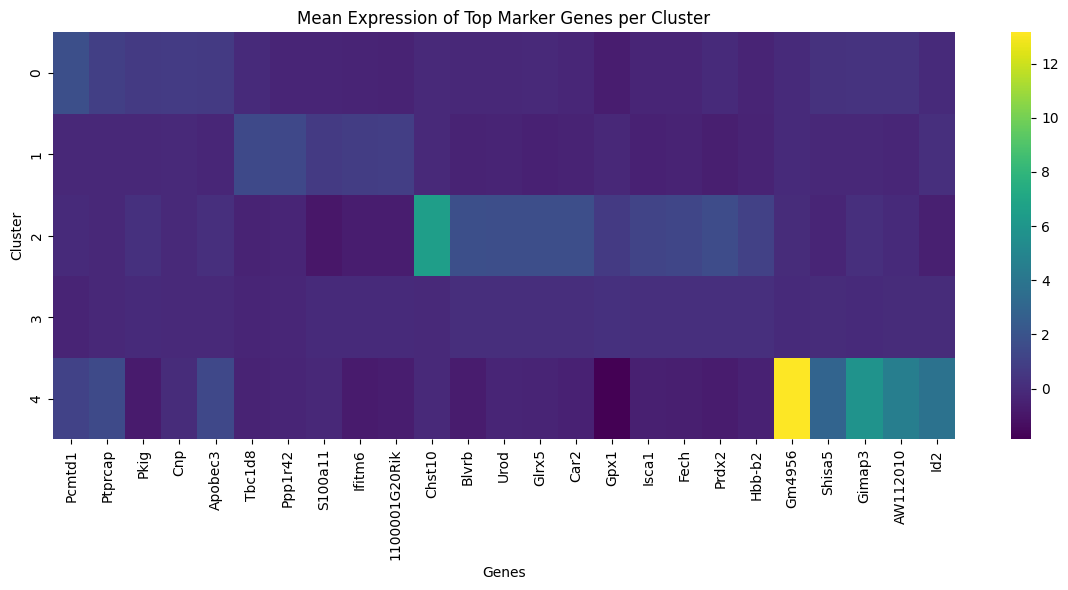

In [15]:
# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(
    expr_df.groupby("cluster").mean(),
    cmap="viridis",
    xticklabels=True,
    yticklabels=True
)
plt.title("Mean Expression of Top Marker Genes per Cluster")
plt.xlabel("Genes")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()

In [16]:
reference_markers = {
    "B_cells": ["Cd79a", "Cd79b", "Ms4a1"],
    "T_cells": ["Cd3d", "Cd3e", "Cd4", "Cd8a"],
    "NK_cells": ["Nkg7", "Klrb1c", "Gzma"],
    "Monocytes": ["Lyz2", "Csf1r", "Cd14"],
    "Dendritic_cells": ["Itgax", "Cd86", "H2-Ab1"],
    "Neutrophils": ["S100a8", "S100a9", "Cxcr2"],
    "Stem_cells": ["Kit", "Ly6a", "Procr"]
}


In [17]:
import pandas as pd

# Load your marker genes
marker_df = pd.read_csv("cluster_marker_genes.csv")

# Define reference marker dictionary
reference_markers = {
    "B_cells": ["Cd79a", "Cd79b", "Ms4a1"],
    "T_cells": ["Cd3d", "Cd3e", "Cd4", "Cd8a"],
    "NK_cells": ["Nkg7", "Klrb1c", "Gzma"],
    "Monocytes": ["Lyz2", "Csf1r", "Cd14"],
    "Dendritic_cells": ["Itgax", "Cd86", "H2-Ab1"],
    "Neutrophils": ["S100a8", "S100a9", "Cxcr2"],
    "Stem_cells": ["Kit", "Ly6a", "Procr"]
}

# Match and suggest labels
cluster_labels = {}

for cluster in marker_df['group'].unique():
    top_genes = marker_df[marker_df['group'] == cluster].head(10)['names'].tolist()
    matched_types = [celltype for celltype, genes in reference_markers.items() if any(g in top_genes for g in genes)]
    cluster_labels[cluster] = matched_types[0] if matched_types else "Unknown"
    print(f"Cluster {cluster} → {cluster_labels[cluster]} (top genes: {top_genes[:3]})")


Cluster 0 → Unknown (top genes: ['Pcmtd1', 'Ptprcap', 'Pkig'])
Cluster 1 → Neutrophils (top genes: ['Tbc1d8', 'Ppp1r42', 'S100a11'])
Cluster 2 → Unknown (top genes: ['Chst10', 'Blvrb', 'Urod'])
Cluster 3 → Unknown (top genes: ['Gpx1', 'Isca1', 'Fech'])
Cluster 4 → Unknown (top genes: ['Gm4956', 'Shisa5', 'Gimap3'])


In [18]:
cluster_map = {
    "0": "Unassigned_0",
    "1": "Neutrophil_like",
    "2": "Unassigned_2",
    "3": "Erythroid_like",
    "4": "Immune_like"
}

clusters = pd.read_csv("cell_clusters.csv")
clusters["annotated_label"] = clusters["cluster"].astype(str).map(cluster_map)
clusters.to_csv("cell_clusters_annotated.csv", index=False)
print("Annotated cluster file saved as 'cell_clusters_annotated.csv'")


Annotated cluster file saved as 'cell_clusters_annotated.csv'


In [19]:
import pandas as pd

# Load updated cluster annotations
annotated_clusters = pd.read_csv("cell_clusters_annotated.csv")

# Assign annotated labels to the AnnData object
adata.obs["annotated_label"] = annotated_clusters["annotated_label"].values


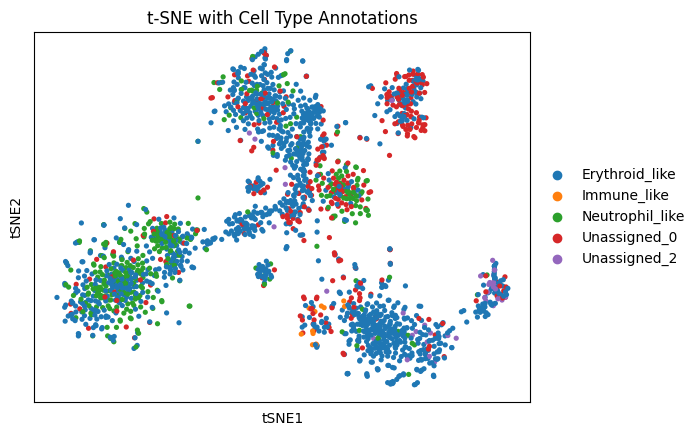

In [20]:
from sklearn.manifold import TSNE

adata.obsm["X_tsne"] = TSNE(n_components=2, random_state=42).fit_transform(adata.X)
sc.pl.embedding(adata, basis="tsne", color="annotated_label", title="t-SNE with Cell Type Annotations")


In [21]:
# Save annotated UMAP to file
sc.pl.umap(
    adata,
    color="annotated_label",
    title="Cell Type Annotation by Cluster",
    legend_loc="on data",
    frameon=False,
    show=False,
    save="_annotated_clusters.png"
)


<AxesSubplot: title={'center': 'Cell Type Annotation by Cluster'}, xlabel='UMAP1', ylabel='UMAP2'>

⚠️ No 'Stem_cells' found. Using first cell as fallback root.


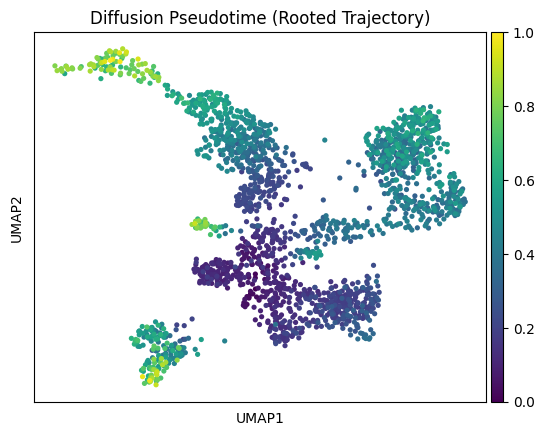

In [22]:
# Step A1: Set the root cell as one from a 'stem-like' or early cluster
# Here we choose the first cell from cluster labeled "Stem" or similar
# You can update this label as needed
stem_cells = adata.obs_names[adata.obs["annotated_label"] == "Stem_cells"]

# Check if we have any — if not, fall back to unassigned
if len(stem_cells) > 0:
    adata.uns['iroot'] = adata.obs_names.get_loc(stem_cells[0])
else:
    print("⚠️ No 'Stem_cells' found. Using first cell as fallback root.")
    adata.uns['iroot'] = 0  # fallback

# Step A2: Compute pseudotime from that root
sc.tl.dpt(adata)

# Step A3: Plot pseudotime over UMAP
sc.pl.umap(
    adata,
    color="dpt_pseudotime",
    title="Diffusion Pseudotime (Rooted Trajectory)",
    color_map="viridis",
    save="_pseudotime_rooted.png",
    show=True
)


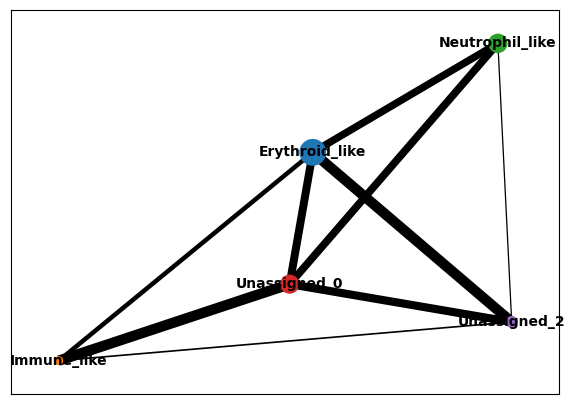

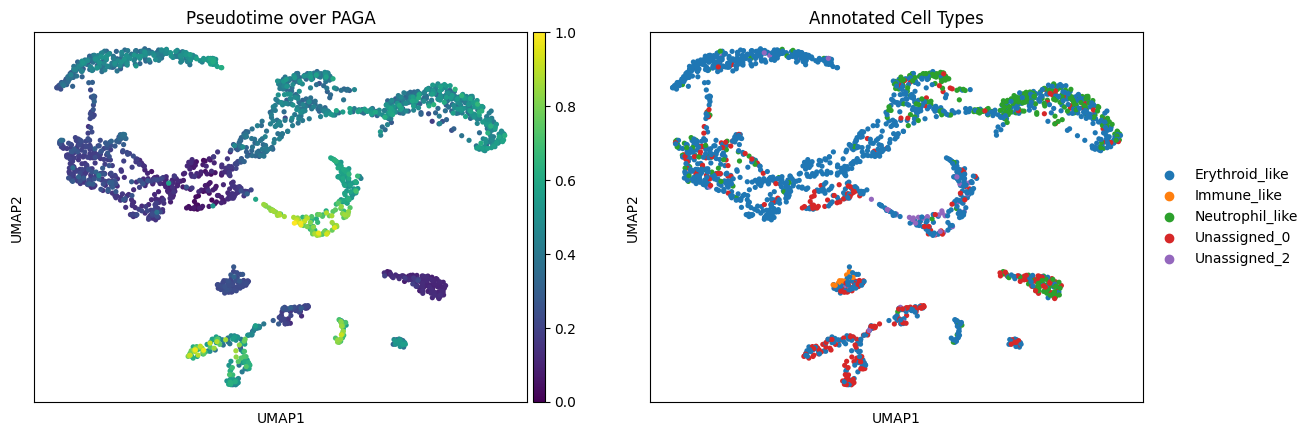

In [23]:
# Step B1: Set the cluster column for PAGA graph abstraction
adata.uns["neighbors"] = adata.uns.get("neighbors", {})  # ensure neighbors exist
sc.tl.paga(adata, groups="annotated_label")

# Step B2: Initialize UMAP using PAGA for topology-preserving embedding
sc.pl.paga(adata, threshold=0.03, show=True, save="_graph.png")
sc.tl.umap(adata, init_pos='paga')

# Step B3: Plot UMAP with PAGA graph and pseudotime
sc.pl.umap(
    adata,
    color=["dpt_pseudotime", "annotated_label"],
    title=["Pseudotime over PAGA", "Annotated Cell Types"],
    save="_paga_pseudotime.png",
    show=True
)


In [24]:
import scipy.stats as stats

# Extract pseudotime and expression matrix
pseudotime = adata.obs["dpt_pseudotime"]
expr_matrix = pd.DataFrame(adata.X, columns=adata.var_names, index=adata.obs_names)

# Calculate correlation between each gene and pseudotime
correlations = {}
for gene in expr_matrix.columns:
    corr, _ = stats.spearmanr(expr_matrix[gene], pseudotime)
    correlations[gene] = corr

# Sort by absolute correlation and select top genes
corr_series = pd.Series(correlations).dropna()
top_dynamic_genes = corr_series.abs().sort_values(ascending=False).head(20)
print("Top dynamic genes:", top_dynamic_genes.index.tolist())


Top dynamic genes: ['Cd24a', 'Pld4', 'Ly86', 'Ahnak', 'Ctss', 'Mpeg1', 'H2-DMa', 'Irf8', 'Ctsh', 'Plac8', 'Lgals1', 'Rnase6', 'Tmsb10', 'Ppfia4', 'Psap', 'Rgs10', 'Bmyc', 'Ms4a6c', 'Itgb7', 'Cd68']


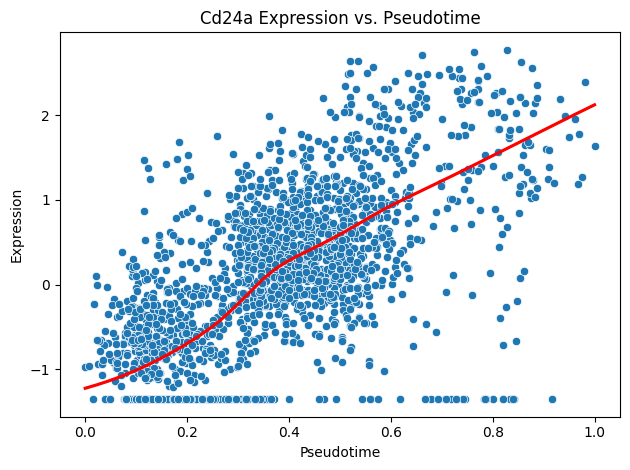

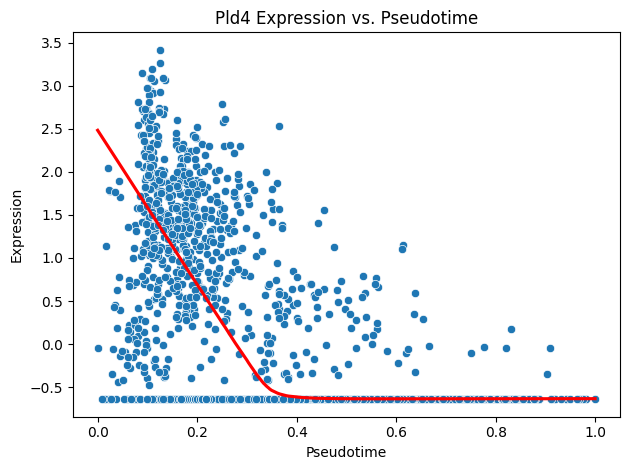

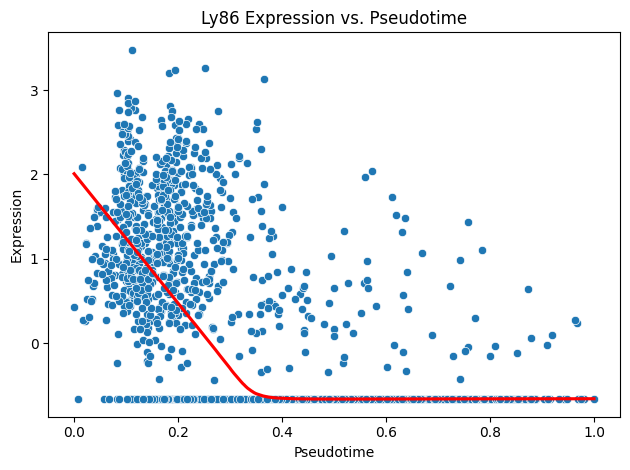

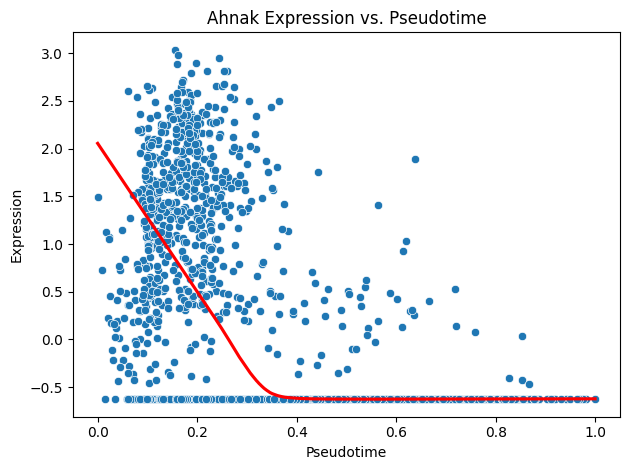

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pick top 4 for visualization
genes_to_plot = top_dynamic_genes.head(4).index.tolist()

# Create pseudotime plots
for gene in genes_to_plot:
    plt.figure()
    sns.scatterplot(x=pseudotime, y=expr_matrix[gene])
    sns.regplot(x=pseudotime, y=expr_matrix[gene], lowess=True, scatter=False, color='red')
    plt.title(f"{gene} Expression vs. Pseudotime")
    plt.xlabel("Pseudotime")
    plt.ylabel("Expression")
    plt.tight_layout()
    plt.savefig(f"figures/{gene}_pseudotime.png")
    plt.show()
